# Loading matrices for shared spatial basis

In [1]:
import numpy as np
from pathlib import Path
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
import hyppo
from graspy.plot import heatmap, pairplot

import sys
from collections import defaultdict

sys.path.append("../")
from src.tools.utils import get_files, get_latents, get_h5

%load_ext autoreload
%autoreload 2
%load_ext nb_black

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [4]:
## Define paths, get raw
base_dir = Path("/mnt/ssd3/ronan/data/gcca_07-09-12:06_min_rank_ZG3/")
# base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/")
# groups, labels, subjs = get_latents(base_dir, flag="_gcca", ids=True)
data_dict = get_h5(base_dir, flag="_gcca")

<IPython.core.display.Javascript object>

In [5]:
data_dict.keys()

dict_keys(['latent', 'loadings', 'projection', 'spatial_pattern', 'state', 'trait', 'subject'])

<IPython.core.display.Javascript object>

In [10]:
subjs = data_dict["subject"]
states = data_dict["state"]
traits = data_dict["trait"]
latents = data_dict["latent"]
projections = data_dict["projection"]
loadings = data_dict["loadings"]
spatial_basis = data_dict["spatial_pattern"][0]

<IPython.core.display.Javascript object>

In [55]:
state_trait = [a + " " + b for a, b in zip(traits, states)]
loading_groups = defaultdict(list)
for loading, label in zip(loadings, y):
    loading_groups[label].append(loading)

<IPython.core.display.Javascript object>

## Visualize

In [17]:
from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl

<IPython.core.display.Javascript object>

In [18]:
# plot on fsa5 surface:
fsa5 = datasets.fetch_surf_fsaverage()
external_dir = Path("../data/external")


def visualize_embeddings(
    embeddings,
    save_path=False,
    vmax=None,
    symmetric_cbar=True,
    colorbar=False,
    n_embed=1,
    title=None,
):
    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(
        n_embed,
        4,
        subplot_kw={"projection": "3d"},
        figsize=(res_scale * 5, res_scale * n_embed),
    )
    if n_embed == 1:
        axes = [axes]

    plt.subplots_adjust(wspace=0, hspace=0)

    for i, ax in enumerate(axes):
        X = embeddings[:, i]

        cortex_left = nib.freesurfer.read_label(external_dir / "lh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_left] = X[: len(cortex_left)]

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu_r",
            axes=ax[0],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_left,
            conn_map,
            hemi="left",
            colorbar=False,
            cmap="RdBu_r",
            view="medial",
            axes=ax[1],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        cortex_right = nib.freesurfer.read_label(external_dir / "rh.cortex.label")

        conn_map = np.zeros(10242)
        conn_map[cortex_right] = X[len(cortex_left) :]

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=False,
            cmap="RdBu_r",
            axes=ax[2],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

        plotting.plot_surf_stat_map(
            fsa5.infl_right,
            conn_map,
            hemi="right",
            colorbar=colorbar,
            cmap="RdBu_r",
            view="medial",
            axes=ax[3],
            vmax=vmax,
            symmetric_cbar=symmetric_cbar,
        )

    if title:
        fig.suptitle(title, fontsize=20, y=0.92)
    if save_path:
        plt.savefig(f"{str(save_path)}.png", format="png", bbox_inches="tight")
    else:
        return fig


#         plt.show()
#         plt.close(fig)


def make_cbar(vmax, save_path=None, vmin=None):
    if vmin is None:
        vmin = -vmax
        cmap = mpl.cm.BuRd_r
    else:
        cmap = mpl.cm.Blues
    fig, ax = plt.subplots(figsize=(1, 15))
    fig.subplots_adjust(bottom=0.5)

    # cmap = mpl.cm.RdBu
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="vertical")

    # cb1.set_clim(vmin, vmax)
    # cb1.set_label('Some Units')
    if save_path:
        plt.savefig(f"{str(save_path)}.pdf", bbox_inches="tight")
    plt.close(fig)

<IPython.core.display.Javascript object>

### Group means / std

<Figure size 432x288 with 0 Axes>

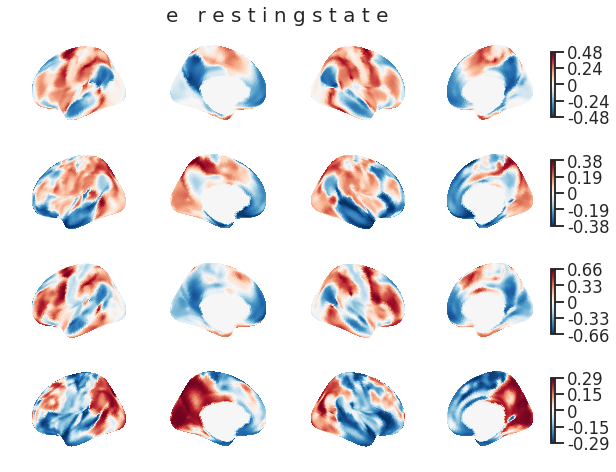

<Figure size 432x288 with 0 Axes>

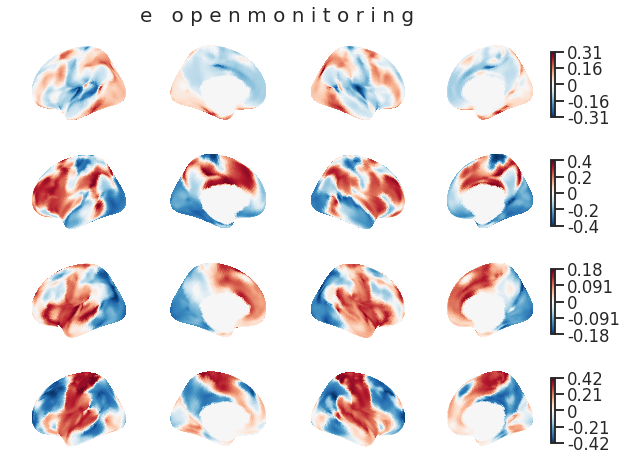

<Figure size 432x288 with 0 Axes>

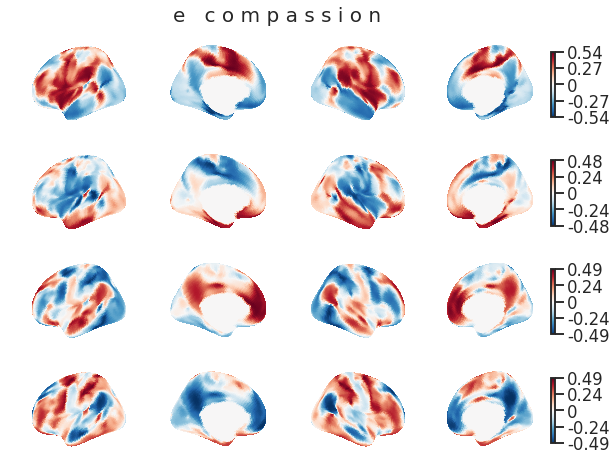

<Figure size 432x288 with 0 Axes>

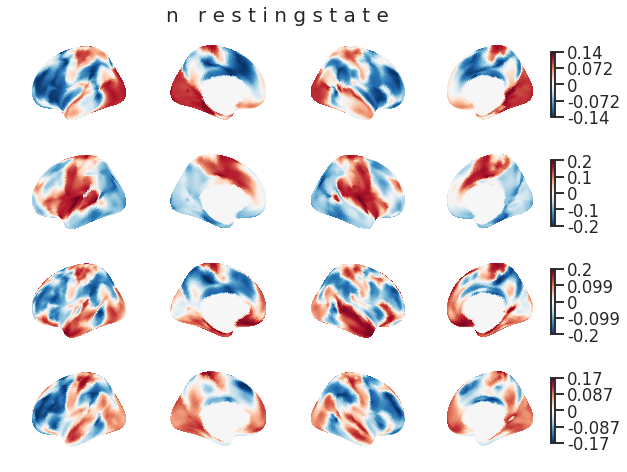

<Figure size 432x288 with 0 Axes>

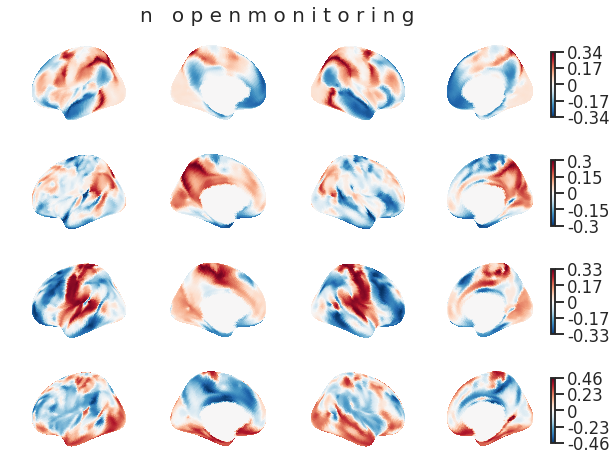

<Figure size 432x288 with 0 Axes>

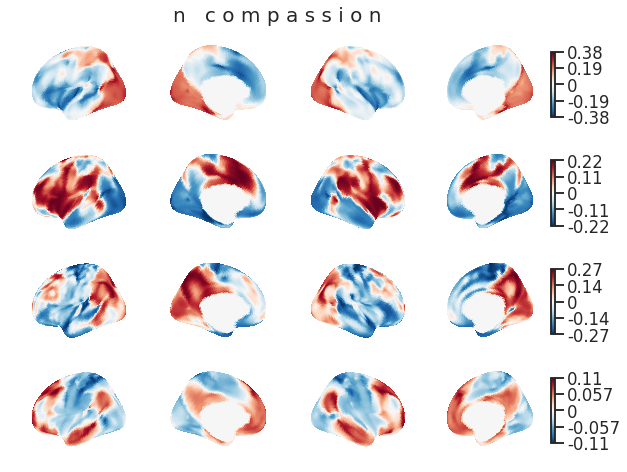

<IPython.core.display.Javascript object>

In [21]:
vmax = None  # max([np.max(np.abs(g)) for g in means])
SAVE = False
COLORBAR = True

for name, loads in loading_groups.items():
    grads = [spatial_basis @ load.T[:, :4] for load in loads]
    mean = np.mean(grads, axis=0)
    std = np.std(grads, axis=0)
    if SAVE:
        title = False
    else:
        title = " ".join(name)

    visualize_embeddings(
        mean / std,
        save_path=False,
        colorbar=COLORBAR,
        n_embed=4,
        vmax=vmax,
        title=title,
    )

    if SAVE:
        # plt.savefig(save_dir / f"{name}_sig_diff_gradients.pdf", bbox_inches="tight")
        plt.show()
    else:
        plt.show()

# if SAVE and not COLORBAR:
#     make_cbar(vmax, save_dir / "sig_diffs_gradients_colorbar")

### Pairwise differences

In [22]:
labels = list(loading_groups.keys())
groups = list(loading_groups.values())

<IPython.core.display.Javascript object>

In [39]:
groups = [[spatial_basis @ load.T[:, :4] for load in group] for group in groups]

<IPython.core.display.Javascript object>

In [32]:
diff_names = [
    "e_rest-vs-n_rest",
    "e_o-vs-n_om",
    "e_comp-vs-n_comp",
    "e_rest-vs-e_om",
    "e_om-vs-e_comp",
    "e_comp-vs-e_om",
    "n_rest-vs-n_om",
    "n_om-vs-n_comp",
    "n_comp-vs-n_rest",
]
diff_idxs = [
    [(0,), (3,)],
    [(1,), (4,)],
    [(2,), (5,)],
    [(0,), (1,)],
    [(1,), (2,)],
    [(2,), (0,)],
    [(3,), (4,)],
    [(4,), (5,)],
    [(5,), (3,)],
]
diffs = []
for (idx1, idx2) in diff_idxs:
    g1 = [groups[i] for i in idx1]
    g2 = [groups[i] for i in idx2]
    n1 = np.sum(len(g) for g in g1)
    n2 = np.sum(len(g) for g in g2)
    std1 = np.vstack(g1).std(0)
    std2 = np.vstack(g2).std(0)
    diff = np.vstack(g1).mean(0) - np.vstack(g2).mean(0)
    ## account for bias
    diff = diff / np.sqrt(
        n1 / (n1 + n2 - 2) * std1 ** 2 + n2 / (n1 + n2 - 2) * std2 ** 2
    )
    diffs.append(diff)

/home/rflperry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/home/rflperry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

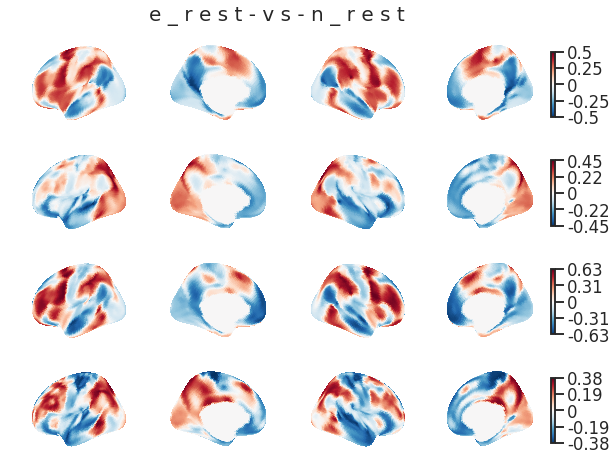

<Figure size 432x288 with 0 Axes>

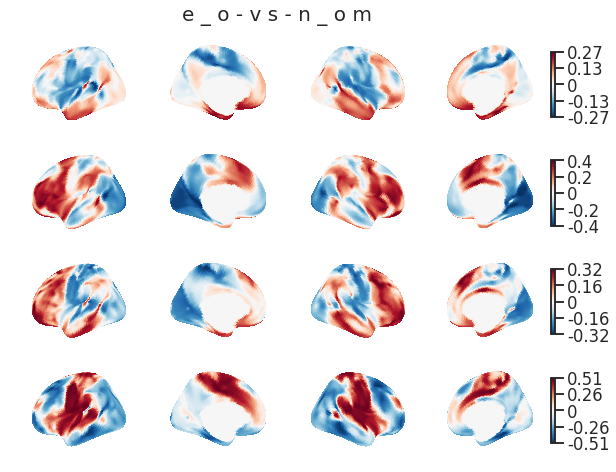

<Figure size 432x288 with 0 Axes>

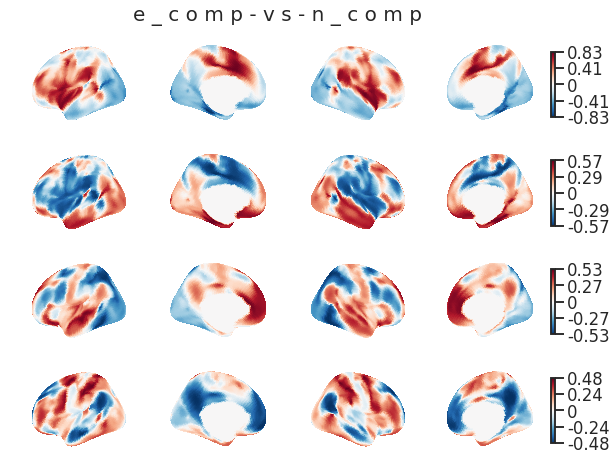

<Figure size 432x288 with 0 Axes>

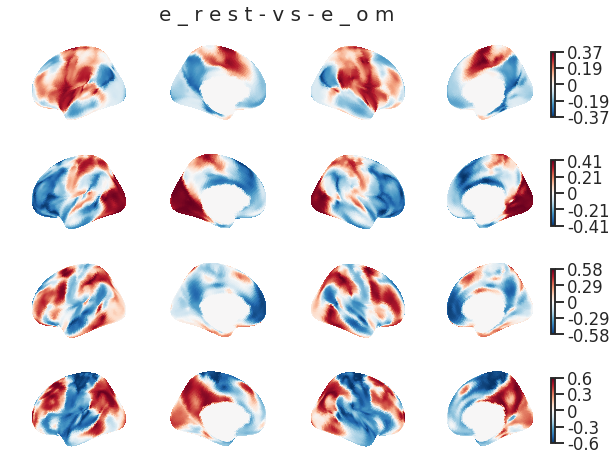

<Figure size 432x288 with 0 Axes>

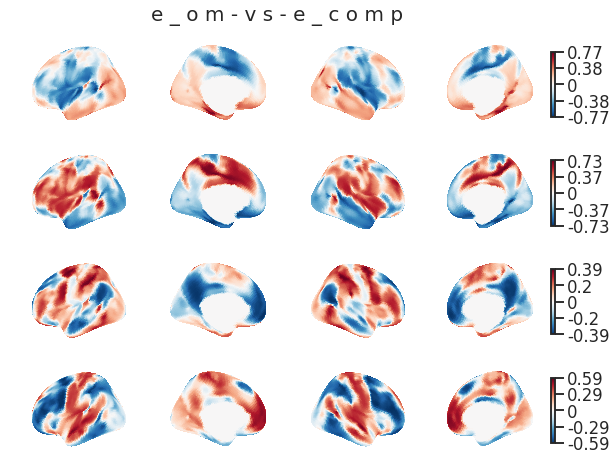

<Figure size 432x288 with 0 Axes>

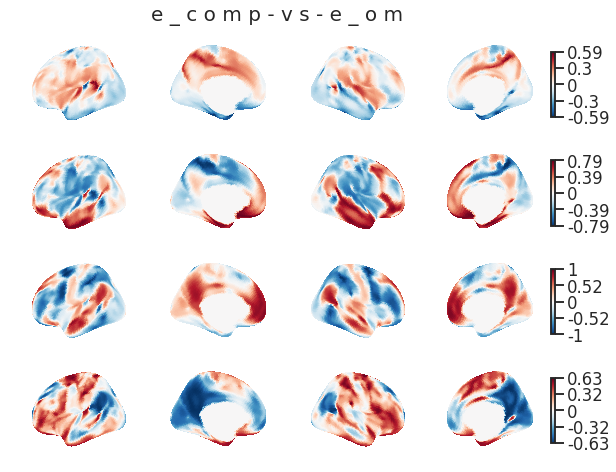

<Figure size 432x288 with 0 Axes>

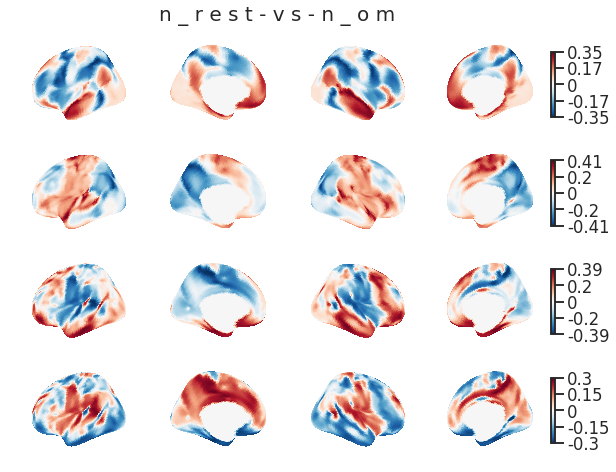

<Figure size 432x288 with 0 Axes>

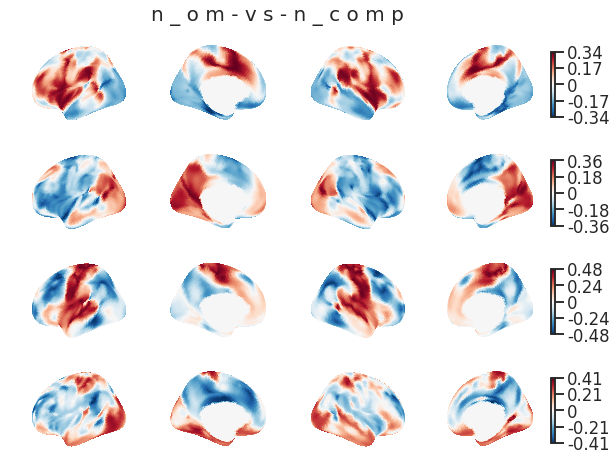

<Figure size 432x288 with 0 Axes>

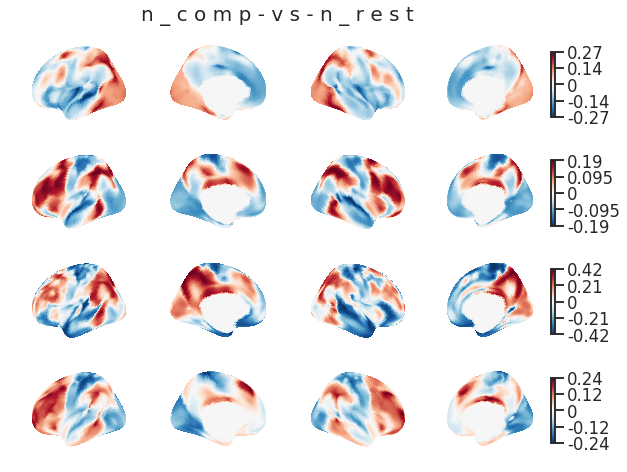

<IPython.core.display.Javascript object>

In [33]:
vmax = None  # max([np.max(np.abs(g)) for g in means])
SAVE = False
COLORBAR = True

for name, diff in zip(diff_names, diffs):
    if SAVE:
        title = False
    else:
        title = " ".join(name)
    visualize_embeddings(
        diff, save_path=False, colorbar=COLORBAR, n_embed=4, vmax=vmax, title=title,
    )

    if SAVE:
        # plt.savefig(save_dir / f"{name}_sig_diff_gradients.pdf", bbox_inches="tight")
        plt.show()
    else:
        plt.show()

In [34]:
from sklearn.utils import check_X_y


def fit_transform(X, y, return_projs=False):
    X, y = check_X_y(
        X, y, dtype=[np.float64, np.float32], ensure_2d=True, copy=True, y_numeric=True
    )

    means = []
    stds = []
    classes = np.unique(y)
    for group in classes:
        Xg = X[y == group, :]
        means.append(Xg.mean(0))
        stds.append(Xg.std(0))

    idx = np.asarray([5, 4, 3, 2, 1, 0])
    delta = np.asarray(means)[idx]

    delta[1:] -= delta[0]

    return X @ delta[1:].T, delta[1:].T, np.asarray(stds).T

<IPython.core.display.Javascript object>

In [46]:
X = np.stack([spatial_basis @ load.T[:, :4] for load in loadings])
X = X[:, :, :3].reshape(X.shape[0], -1)

<IPython.core.display.Javascript object>

## LOL

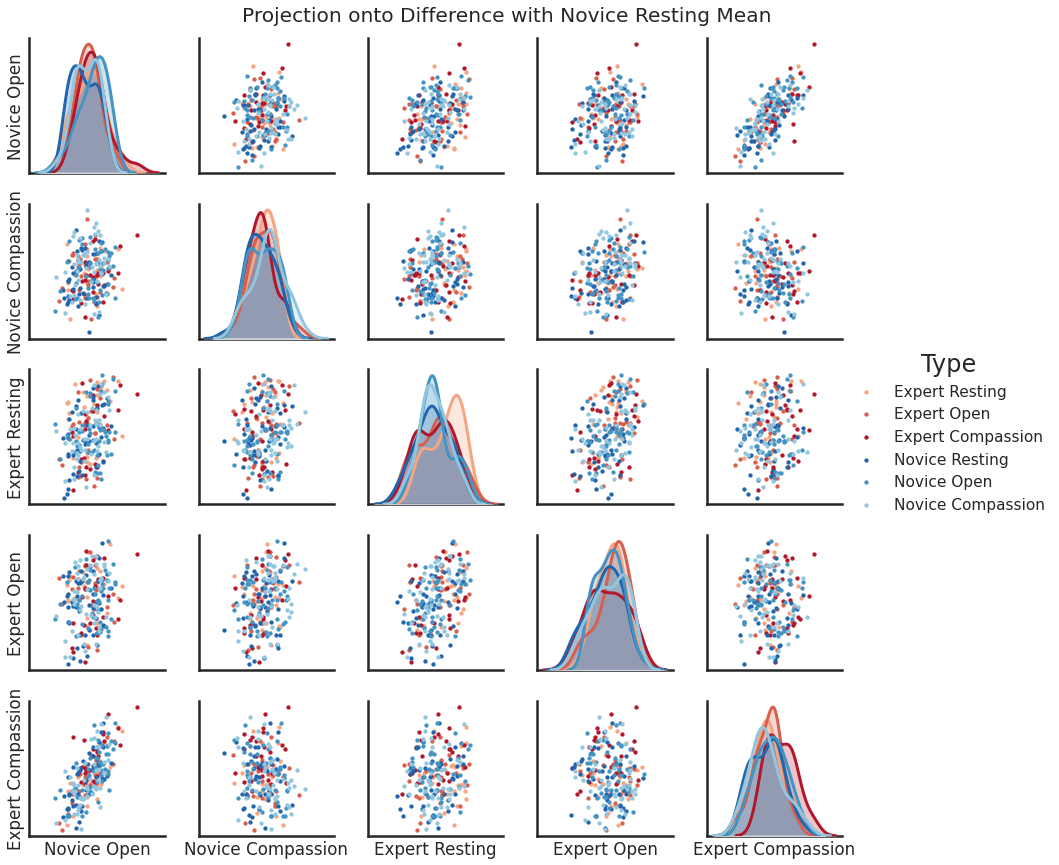

<IPython.core.display.Javascript object>

In [47]:
proj, _, _ = fit_transform(X, y)
xticklabels = [
    "Novice Open",
    "Novice Compassion",
    "Expert Resting",
    "Expert Open",
    "Expert Compassion",
]
class_labels = {
    "e restingstate": "Expert Resting",
    "e openmonitoring": "Expert Open",
    "e compassion": "Expert Compassion",
    "n restingstate": "Novice Resting",
    "n openmonitoring": "Novice Open",
    "n compassion": "Novice Compassion",
}
# RedBu 9
colors = [
    "#b2182b",
    "#d6604d",
    "#f4a582",
    "#92c5de",
    "#4393c3",
    "#2166ac",
]
proj_labels = [class_labels[st] for st in y]
pairplot(
    proj,
    proj_labels,
    col_names=xticklabels,
    variables=xticklabels,
    palette={
        name: col
        for name, col in zip(np.unique([class_labels[st] for st in y]), colors)
    },
    title=f"Projection onto Difference with Novice Resting Mean",
    alpha=1.0,
    size=75,
    context="poster",
    font_scale=0.7,
)

## MGC

In [82]:
labels = list(loading_groups.keys())
groups = list(loading_groups.values())

<IPython.core.display.Javascript object>

In [83]:
groups = [[load.T[:, :4] for load in group] for group in groups]

<IPython.core.display.Javascript object>

In [85]:
diff_names = [
    "e_rest-vs-n_rest",
    "e_o-vs-n_om",
    "e_comp-vs-n_comp",
    "e_rest-vs-e_om",
    "e_om-vs-e_comp",
    "e_comp-vs-e_rest",
    "n_rest-vs-n_om",
    "n_om-vs-n_comp",
    "n_comp-vs-n_rest",
]
diff_idxs = [
    [(0), (3)],
    [(1), (4)],
    [(2), (5)],
    [(0), (1)],
    [(1), (2)],
    [(2), (0)],
    [(3), (4)],
    [(4), (5)],
    [(5), (3)],
]
for name, idxs in zip(diff_names, diff_idxs):
    print(f"----------------- {name} -----------------")
    X, Y = k_sample_transform(
        [np.stack(groups[idx])[:, :, 0].reshape(len(groups[idx]), -1) for idx in idxs]
    )
    stat, pvalue, mgc_dict = multiscale_graphcorr(X, Y, workers=-1, reps=1000)
    print(f"stat {stat}")
    print(f"pval {pvalue}")

----------------- e_rest-vs-n_rest -----------------
stat -0.0033879596597438774
pval 0.474
----------------- e_o-vs-n_om -----------------
stat -0.011572111655592394
pval 0.705
----------------- e_comp-vs-n_comp -----------------
stat 0.02920567295638915
pval 0.085
----------------- e_rest-vs-e_om -----------------
stat -0.014294321300589226
pval 0.677
----------------- e_om-vs-e_comp -----------------
stat -0.002613046135002604
pval 0.432
----------------- e_comp-vs-e_rest -----------------
stat -0.016983042390167777
pval 0.76
----------------- n_rest-vs-n_om -----------------
stat -0.008179167015922775
pval 0.654
----------------- n_om-vs-n_comp -----------------
stat -0.01107136294649576
pval 0.812
----------------- n_comp-vs-n_rest -----------------
stat -0.014076152771126149
pval 0.886


<IPython.core.display.Javascript object>

## Intra subject differences

In [48]:
subj_scans = defaultdict(lambda: defaultdict(dict))
for state, trait, subj, loading in zip(states, traits, subjs, loadings):
    subj_scans[subj][state] = spatial_basis @ loading.T[:, :4]
    subj_scans[subj]["trait"] = trait

<IPython.core.display.Javascript object>

In [49]:
subj_diffs = []
subj_traits = []
for key, d in subj_scans.items():
    try:
        subj_diffs.append(
            [
                np.linalg.norm(d["compassion"] - d["restingstate"]),
                np.linalg.norm(d["openmonitoring"] - d["restingstate"]),
                np.linalg.norm(d["compassion"] - d["openmonitoring"]),
            ]
        )
        subj_traits.append(d["trait"])
    except:
        print(f"subj {key}")
subj_diffs = np.asarray(subj_diffs)

<IPython.core.display.Javascript object>

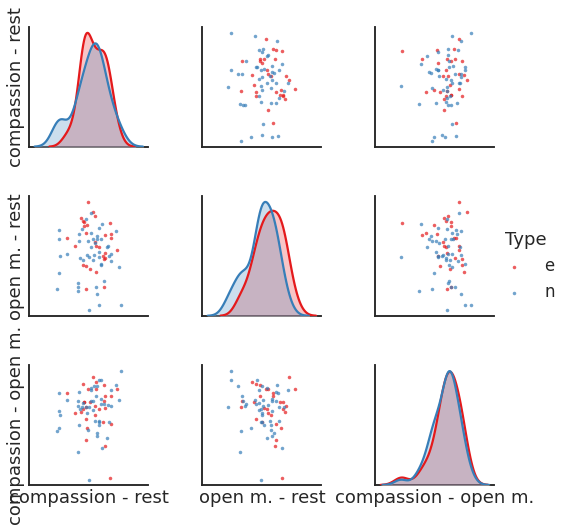

<IPython.core.display.Javascript object>

In [57]:
pairplot(
    np.asarray(subj_diffs),
    subj_traits,
    col_names=["compassion - rest", "open m. - rest", "compassion - open m."],
)

## Loadings

In [65]:
X = np.stack([l.T[:, :4] for l in loadings])

<IPython.core.display.Javascript object>

In [67]:
colors = [
    "#b2182b",
    "#d6604d",
    "#f4a582",
    "#92c5de",
    "#4393c3",
    "#2166ac",
]

<IPython.core.display.Javascript object>

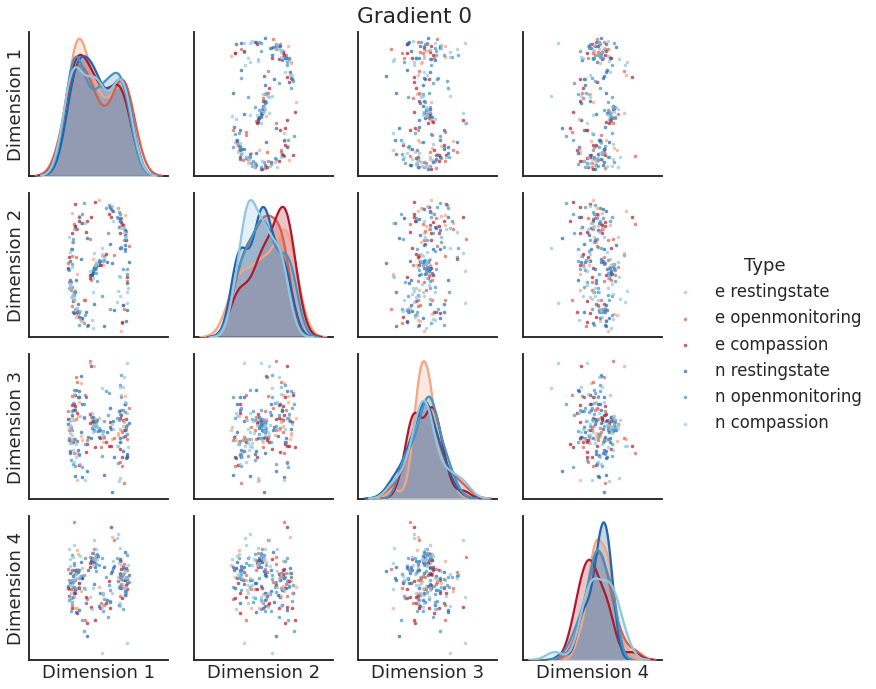

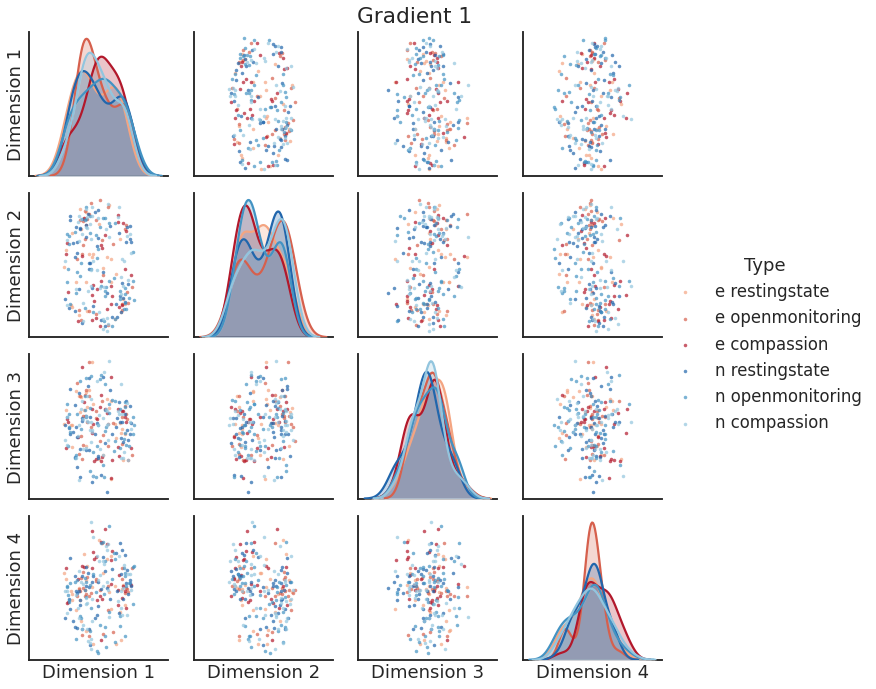

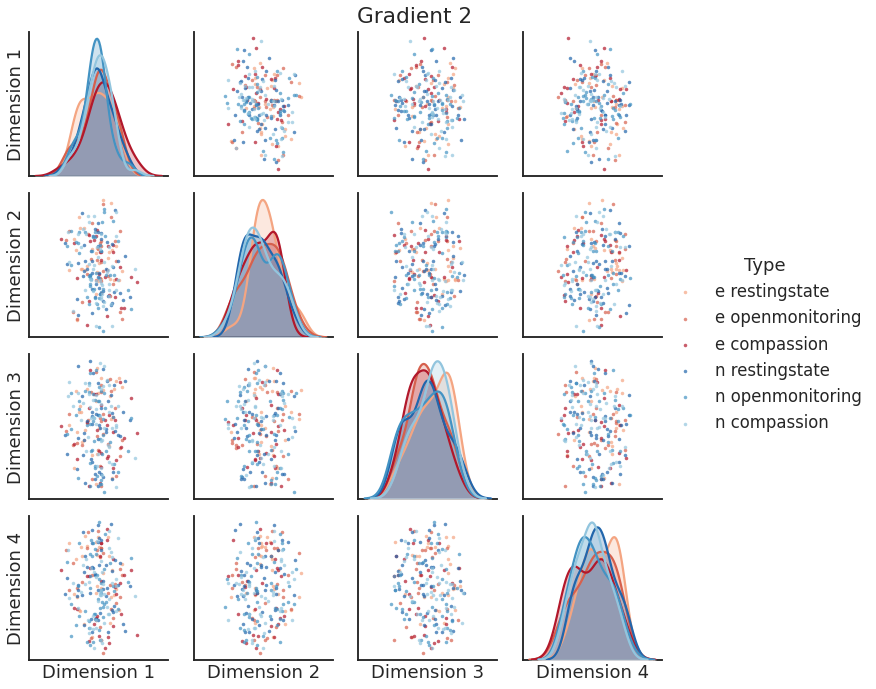

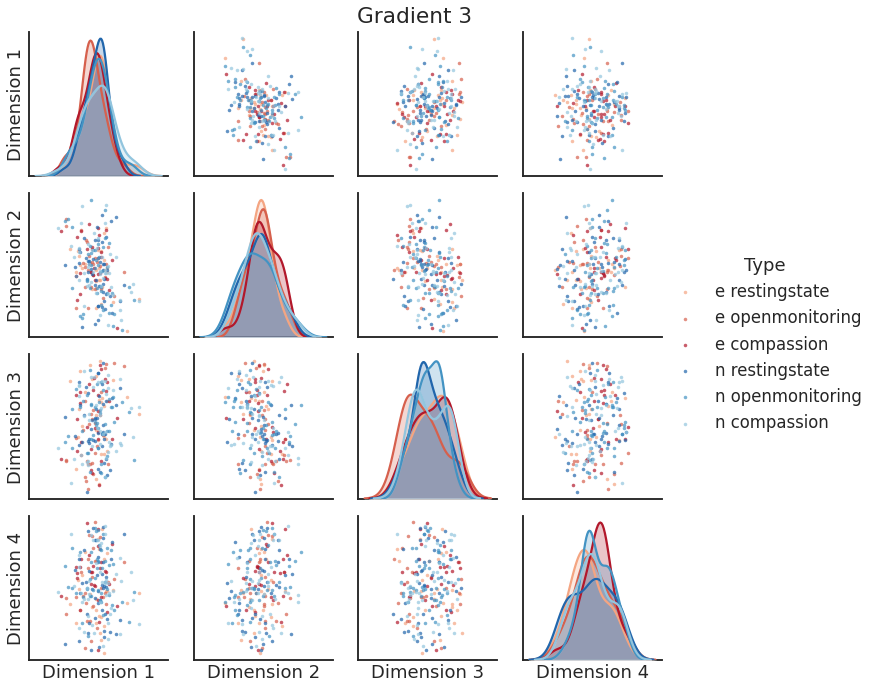

<IPython.core.display.Javascript object>

In [69]:
for i in range(4):
    g = pairplot(
        X[:, :, i],
        state_trait,
        title=f"Gradient {i}",
        palette={name: col for name, col in zip(np.unique(state_trait), colors)},
    )

In [70]:
subj_scans = defaultdict(lambda: defaultdict(dict))
for state, trait, subj, loading in zip(states, traits, subjs, loadings):
    subj_scans[subj][state] = loading.T[:, :4]
    subj_scans[subj]["trait"] = trait

<IPython.core.display.Javascript object>

In [71]:
subj_diffs = []
subj_traits = []
for key, d in subj_scans.items():
    try:
        subj_diffs.append(
            [
                np.linalg.norm(d["compassion"] - d["restingstate"]),
                np.linalg.norm(d["openmonitoring"] - d["restingstate"]),
                np.linalg.norm(d["compassion"] - d["openmonitoring"]),
            ]
        )
        subj_traits.append(d["trait"])
    except:
        print(f"subj {key}")
subj_diffs = np.asarray(subj_diffs)

<IPython.core.display.Javascript object>

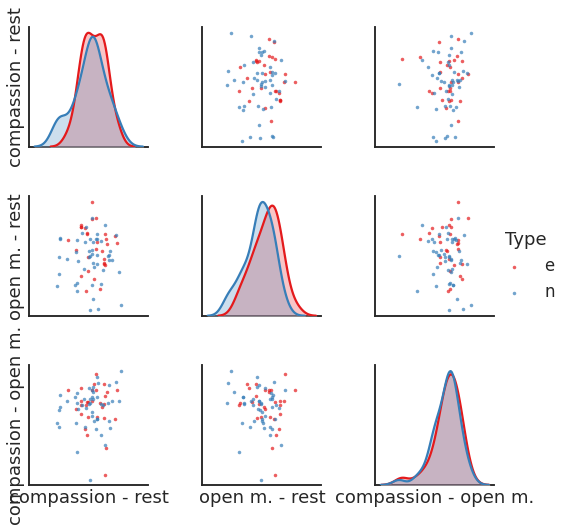

<IPython.core.display.Javascript object>

In [72]:
pairplot(
    np.asarray(subj_diffs),
    subj_traits,
    col_names=["compassion - rest", "open m. - rest", "compassion - open m."],
)